In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.formula.api as smf

## Wine retailer experiment
original author: Elea McDonnell Feit 6/10/2019, adapted for OMSBAM GBA 474  


**Test setting**: email to retailer customers

**Unit**: customer (email address)

**Treatments**: email version A, email version B, holdout

**Reponse**: open, click and 1-month purchase (\$)

**Selection**: all active customers

**Assignment**: randomly assigned (1/3 each) to email A, email B or control (ctrl)

In [42]:
data = pd.read_csv('data_targeting_wine.csv')
data

,user_id,cpgn_id,group,open,click,purch,past_purch,last_purch,visits
0,1000001,1901Email,ctrl,0,0,0.00,33.94,119,11
1,1000002,1901Email,email_B,0,0,0.00,92.54,60,3
2,1000003,1901Email,email_A,1,1,12.95,533.02,9,9
3,1000004,1901Email,email_A,0,0,0.00,41.21,195,6
4,1000005,1901Email,email_B,1,0,18.85,1649.01,48,9
...,...,...,...,...,...,...,...,...,...
123983,1123984,1901Email,ctrl,0,0,0.00,414.70,138,7
123984,1123985,1901Email,ctrl,0,0,0.00,85.27,159,6
123985,1123986,1901Email,ctrl,0,0,0.00,53.38,16,10
123986,1123987,1901Email,email_A,1,0,0.00,39.31,30,9


## Types of variables associated with experiment
- **Treatment indicator** (W's)
    - Which (randomized) treatment was received  
    - Here these are group: email A, B (grouped together as email) or ctrl
      
- **Response** (Y's)
    - Outcome(s) measured for each customer. Aka the DV or dependent variable.  
    - Here these are: open, click, and purch
    
- **Baseline variables** ("X's")
    - Other features we know about customers **prior** to the randomization  
    - here includes: 
    - total purchases in past year (past_purch)
    - days since last purchase or 2 years if more than 2 years ago (last_purch)
    - number of website visits (visits)


We can depict the average effects in table and graph form as follows:

In [43]:
summ = data.groupby('group').agg({'purch': ['count', 'mean', 'std'], 'open': ['mean', 'std'], 'click': ['mean', 'std']})
summ.columns = ['count', 'purch_mean', 'purch_std', 'open_mean', 'open_std', 'click_mean', 'click_std']
summ = summ.reset_index()
summ

,group,count,purch_mean,purch_std,open_mean,open_std,click_mean,click_std
0,ctrl,41330,12.321663,42.248307,0.000000,0.000000,0.000000,0.000000
1,email_A,41329,13.815919,46.855404,0.717099,0.450414,0.131530,0.337983
2,email_B,41329,13.683477,44.961076,0.653681,0.475802,0.089695,0.285748


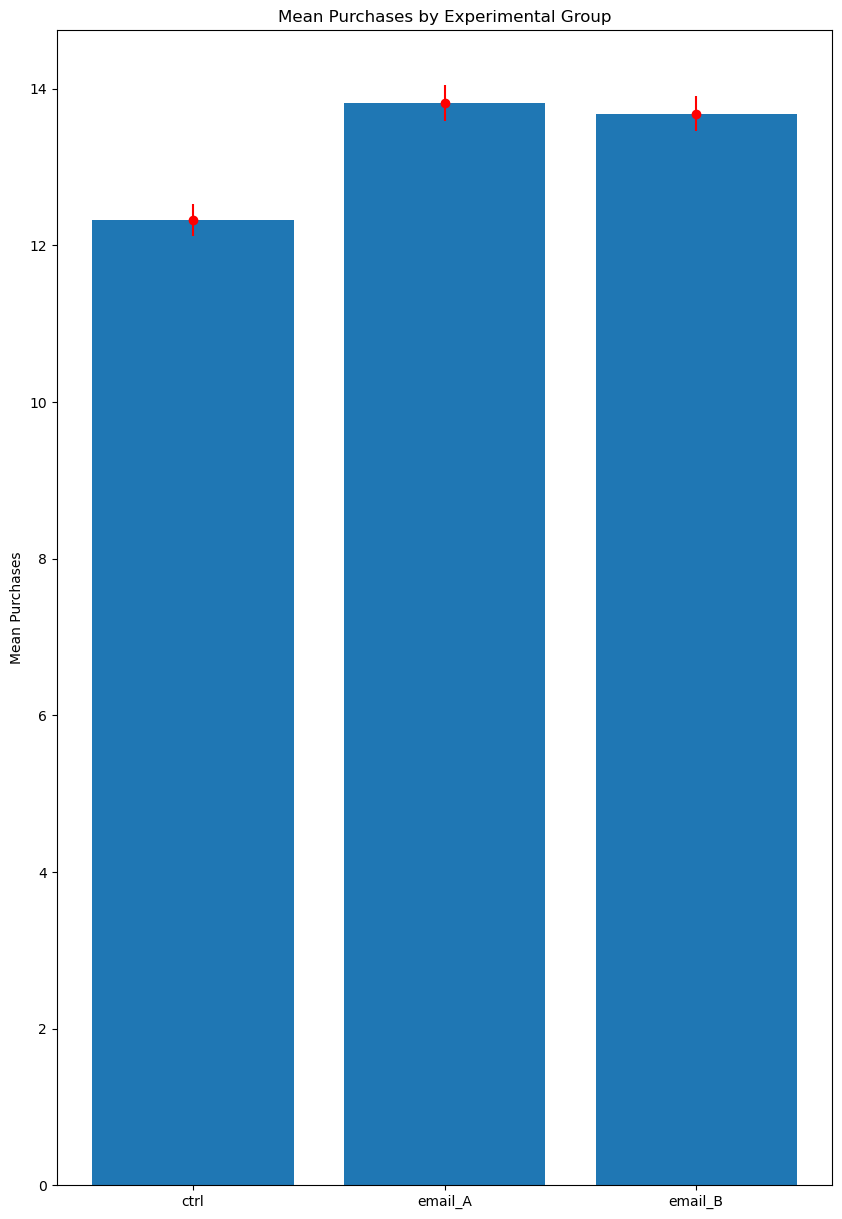

In [44]:
plt.figure(figsize = (10,15))

plt.bar(summ['group'], summ['purch_mean'])

error = summ['purch_std']/np.sqrt(summ['count'])
plt.errorbar(summ['group'], summ['purch_mean'], yerr=error, fmt="o", color="r")
plt.title("Mean Purchases by Experimental Group")
plt.ylabel('Mean Purchases')

plt.show()

##Average Treatment Effects

To evaluate the average causal effect on purchases we use linear regression as follows. 



In [45]:
model = smf.ols(formula ="purch ~ group", data=data).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                  purch   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     14.13
Date:                Sun, 01 Dec 2024   Prob (F-statistic):           7.29e-07
Time:                        23:02:35   Log-Likelihood:            -6.4716e+05
No. Observations:              123988   AIC:                         1.294e+06
Df Residuals:                  123985   BIC:                         1.294e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           12.3217      0.220  

In [46]:
pd.DataFrame(model.params, columns = ['Coefficient'])

,Coefficient
Intercept,12.321663
group[T.email_A],1.494256
group[T.email_B],1.361814


All effects are both highly significant and the effect sizes are \\$1.49 for email A and \$1.36 for email B. Notice further that the two emails do not appear to be significantly different from one another. As a result, we create a variable, emailTRUE, that pools the two together. We then rerun the analysis with the pooled variables. 

In [47]:
data['email'] = data['group'] != 'ctrl'
data

,user_id,cpgn_id,group,open,click,purch,past_purch,last_purch,visits,email
0,1000001,1901Email,ctrl,0,0,0.00,33.94,119,11,False
1,1000002,1901Email,email_B,0,0,0.00,92.54,60,3,True
2,1000003,1901Email,email_A,1,1,12.95,533.02,9,9,True
3,1000004,1901Email,email_A,0,0,0.00,41.21,195,6,True
4,1000005,1901Email,email_B,1,0,18.85,1649.01,48,9,True
...,...,...,...,...,...,...,...,...,...,...
123983,1123984,1901Email,ctrl,0,0,0.00,414.70,138,7,False
123984,1123985,1901Email,ctrl,0,0,0.00,85.27,159,6,False
123985,1123986,1901Email,ctrl,0,0,0.00,53.38,16,10,False
123986,1123987,1901Email,email_A,1,0,0.00,39.31,30,9,True


In [48]:
model = smf.ols(formula ="purch ~ email", data=data).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                  purch   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     28.09
Date:                Sun, 01 Dec 2024   Prob (F-statistic):           1.16e-07
Time:                        23:02:37   Log-Likelihood:            -6.4716e+05
No. Observations:              123988   AIC:                         1.294e+06
Df Residuals:                  123986   BIC:                         1.294e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        12.3217      0.220     56.004

## Baseline variable: Days since last purchase

Looking at the distribution of the variable last_purch.  We will define "recent purchasers" customers who have made a purchase in the last 60 days.

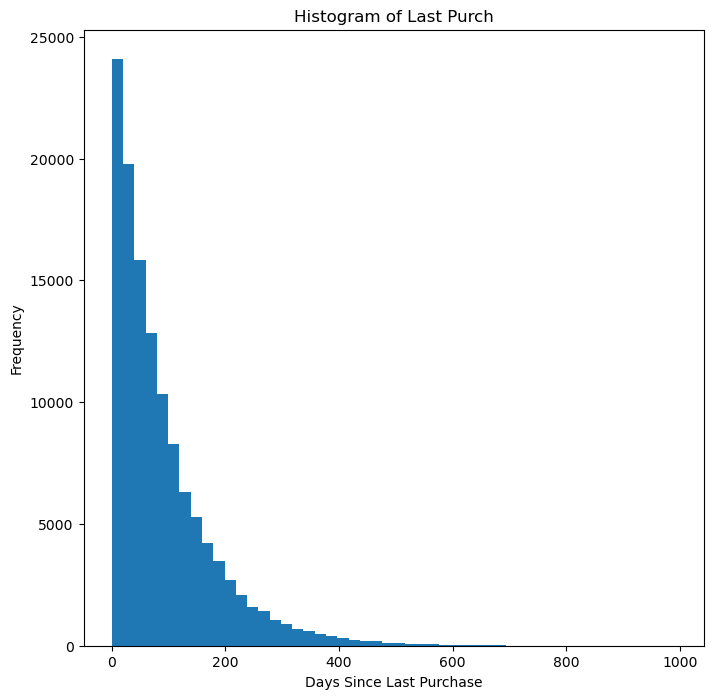

In [49]:
plt.figure(figsize=(8,8))

n, bins, patches = plt.hist(data['last_purch'], bins = 50)
plt.xlabel('Days Since Last Purchase')
plt.ylabel('Frequency')
plt.title('Histogram of Last Purch')
plt.show()

In [50]:
data['recentPurch'] = data['last_purch'] < 60
data

,user_id,cpgn_id,group,open,click,purch,past_purch,last_purch,visits,email,recentPurch
0,1000001,1901Email,ctrl,0,0,0.00,33.94,119,11,False,False
1,1000002,1901Email,email_B,0,0,0.00,92.54,60,3,True,False
2,1000003,1901Email,email_A,1,1,12.95,533.02,9,9,True,True
3,1000004,1901Email,email_A,0,0,0.00,41.21,195,6,True,False
4,1000005,1901Email,email_B,1,0,18.85,1649.01,48,9,True,True
...,...,...,...,...,...,...,...,...,...,...,...
123983,1123984,1901Email,ctrl,0,0,0.00,414.70,138,7,False,False
123984,1123985,1901Email,ctrl,0,0,0.00,85.27,159,6,False,False
123985,1123986,1901Email,ctrl,0,0,0.00,53.38,16,10,False,True
123986,1123987,1901Email,email_A,1,0,0.00,39.31,30,9,True,True


Is email more effective for recent buyers? 

In [51]:
summ = data.groupby(['recentPurch','email']).agg({'purch': ['mean', 'std', 'count']})
summ.columns = ['purch_mean', 'purch_std', 'purch_count']
summ = summ.reset_index()

cross_tab = pd.pivot_table(
    summ,
    values='purch_mean',  
    index='email',
    columns='recentPurch',
    aggfunc='mean',  
    fill_value=0
)

cross_tab

recentPurch,False,True
email,,
False,6.406703,18.667363
True,7.288236,20.717406


## Conditional Treatment Effects

To evaluate the average causal effect on purchases we use linear regression as follows. 

In [52]:
model = smf.ols(formula ="purch ~ email*recentPurch", data=data).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  purch   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     907.1
Date:                Sun, 01 Dec 2024   Prob (F-statistic):               0.00
Time:                        23:02:43   Log-Likelihood:            -6.4583e+05
No. Observations:              123988   AIC:                         1.292e+06
Df Residuals:                  123984   BIC:                         1.292e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

In [53]:
pd.DataFrame(model.params, columns = ['Coefficient'])

,Coefficient
Intercept,6.406703
email[T.True],0.881533
recentPurch[T.True],12.260661
email[T.True]:recentPurch[T.True],1.168509


The main effect of the email variable is significant still, leading to $0.88 more sales. However, the interpretation is different. Now this effect relates to the omitted group from the interaction effect (when the recentPurch variable=0 or FALSE). Hence, the effect of emailTRUE is for those that have not bought recently. This group of customers are still significantly affected by the email.  

This analysis reveals two other things about subgroups of customers. 

1. Subgroups will vary in how much they engage in behaviors (main effect of baseline variables)
    - Recent buyers tend to have \$12.26 higher average purchases in the future
   
2. Subgroups vary in how much they respond to treatments (interaction effects)
    - Recent buyers are more affected by the email, leading to addition \$1.17 in spending

Since the segmentation variable is categorical, to interpret the exact level of effect for each of the subgroups we use the main for the omitted group, and we add the main and interaction effects together for the included group. Here that means that the customers without recent purchases have an effect of \$0.88 and the customers with recent purchase have an effect of \\$2.05. 

We can also obtain this by rerunning the analysis in a slightly different formula as shown below:

In [54]:
model = smf.ols(formula ="purch ~ recentPurch + email:recentPurch", data=data).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  purch   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     907.1
Date:                Sun, 01 Dec 2024   Prob (F-statistic):               0.00
Time:                        23:02:47   Log-Likelihood:            -6.4583e+05
No. Observations:              123988   AIC:                         1.292e+06
Df Residuals:                  123984   BIC:                         1.292e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

Finally, we could also get the results by running regressions separately for recentPurch = True and recentPurch = False

In [55]:
model = smf.ols(formula ="purch ~ email", data=data[data['recentPurch']]).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  purch   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     19.53
Date:                Sun, 01 Dec 2024   Prob (F-statistic):           9.90e-06
Time:                        23:02:49   Log-Likelihood:            -3.2230e+05
No. Observations:               59710   AIC:                         6.446e+05
Df Residuals:                   59708   BIC:                         6.446e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        18.6674      0.379     49.312

In [36]:
model = smf.ols(formula ="purch ~ email", data=data[~data['recentPurch']]).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  purch   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     9.878
Date:                Sun, 01 Dec 2024   Prob (F-statistic):            0.00167
Time:                        22:47:50   Log-Likelihood:            -3.1694e+05
No. Observations:               64278   AIC:                         6.339e+05
Df Residuals:                   64276   BIC:                         6.339e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         6.4067      0.229     27.964

Some sample code when you have more than one group...

In [61]:
data_model = data.copy()

data_model['group'] = pd.Categorical(
    data_model['group'], 
    categories=['ctrl', 'email_A', 'email_B'],  # Specify the order explicitly
    ordered=True
)

data_model = pd.get_dummies(data_model, columns=['group'], drop_first=True)

formula = "purch ~ recentPurch * (group_email_A + group_email_B)"

# Fit the regression model
model = smf.ols(formula=formula, data=data_model).fit()

# Display the regression summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  purch   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     544.4
Date:                Sun, 01 Dec 2024   Prob (F-statistic):               0.00
Time:                        23:04:13   Log-Likelihood:            -6.4583e+05
No. Observations:              123988   AIC:                         1.292e+06
Df Residuals:                  123982   BIC:                         1.292e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------